In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rcParams

Load Dataset

In [2]:
dataset = 'mountains_vs_beaches_preferences.csv'
df = pd.read_csv(dataset)

#### check if there is missing data

In [3]:
missing_data = df.isnull().sum()
missing_data

Age                       0
Gender                    0
Income                    0
Education_Level           0
Travel_Frequency          0
Preferred_Activities      0
Vacation_Budget           0
Location                  0
Proximity_to_Mountains    0
Proximity_to_Beaches      0
Favorite_Season           0
Pets                      0
Environmental_Concerns    0
Preference                0
dtype: int64

As we can see here, there is no missing values, so we do not need any cleaning.

### Create a correlation heat-map

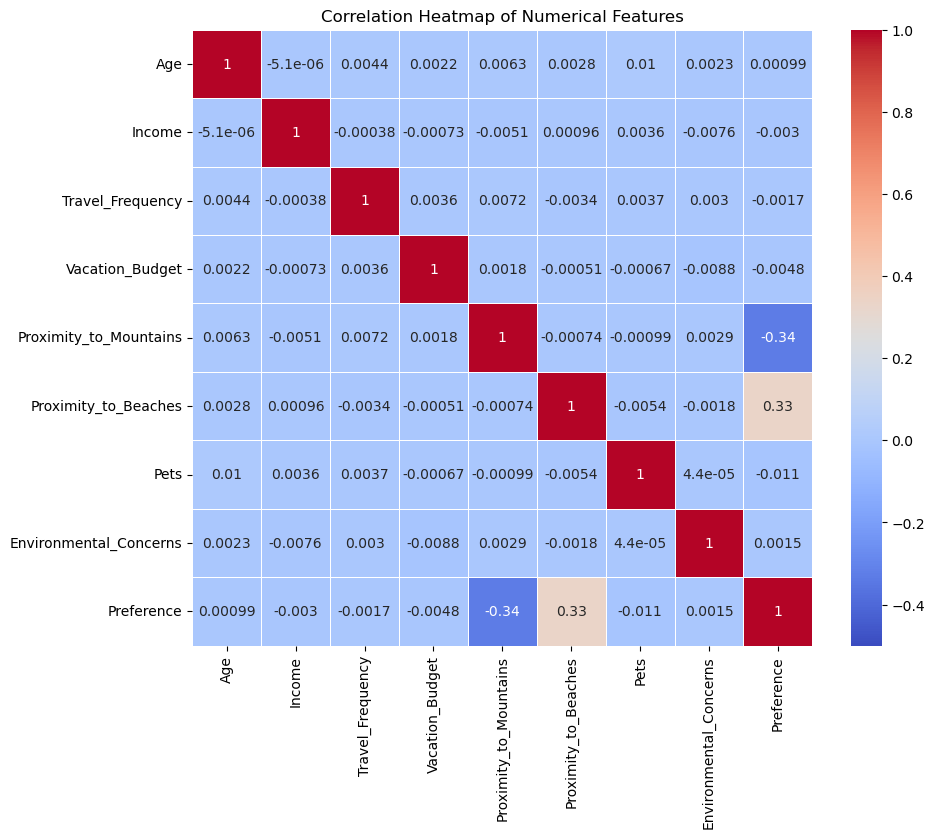

In [4]:
# Correlation heatmap for numerical features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Question 1
How Proximity Affects Preferences

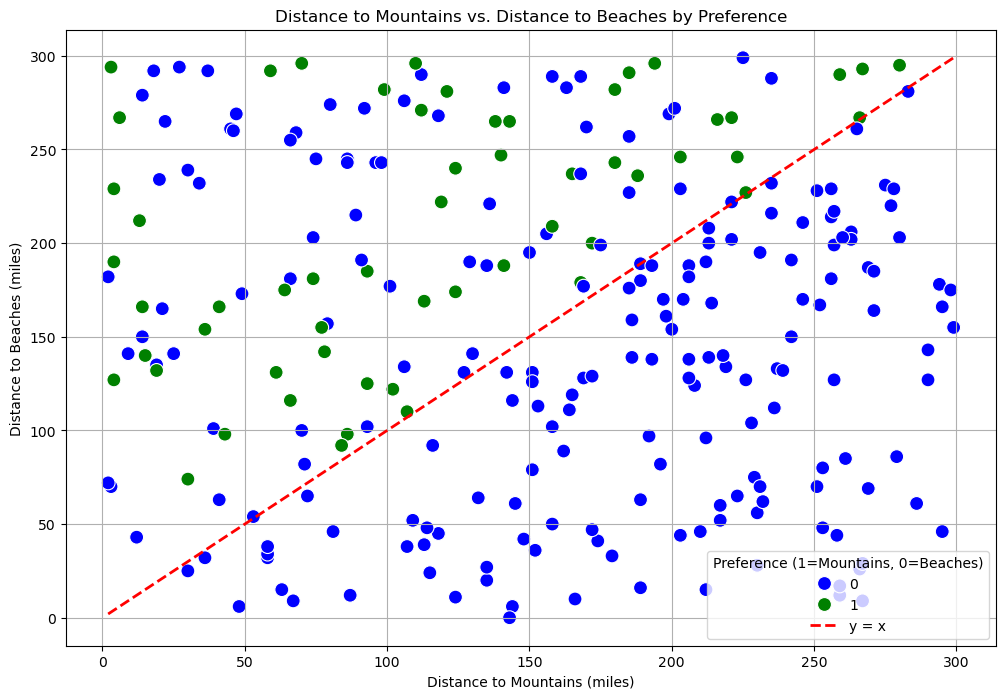

In [5]:
# Scatter plot: Distance to Mountains vs. Distance to Beaches, colored by preference
df_sampled = df.sample(frac=0.005, random_state=42)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_sampled, x='Proximity_to_Mountains', y='Proximity_to_Beaches', hue='Preference', palette={1: 'green', 0: 'blue'}, s=100)
plt.plot([df_sampled['Proximity_to_Mountains'].min(), df_sampled['Proximity_to_Mountains'].max()],
[df_sampled['Proximity_to_Mountains'].min(), df_sampled['Proximity_to_Mountains'].max()],
color='red', linestyle='--', linewidth=2, label='y = x')
plt.title('Distance to Mountains vs. Distance to Beaches by Preference')
plt.xlabel('Distance to Mountains (miles)')
plt.ylabel('Distance to Beaches (miles)')
plt.legend(title='Preference (1=Mountains, 0=Beaches)')
plt.grid(True)
plt.show()


The scatter plot reveals that individuals who live close to both mountains and beaches (upper left area) show mixed preferences for mountains or beaches, while those living far from beaches but close to mountains (lower right area) predominantly prefer beaches. This pattern suggests that proximity influences vacation choices, but factors like the desire for environmental contrast, accessibility, and socioeconomic conditions also play significant roles.

In [6]:
from scipy.stats import chi2_contingency

df['closer_to_mountains'] = np.where(df['Proximity_to_Mountains'] - df['Proximity_to_Beaches'] > 0, 1, 0)
contingency_table = pd.crosstab(df['closer_to_mountains'], df['Preference'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
alpha = 0.05
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p}")
if p < alpha:
    print("Reject the null hypothesis: People closer to mountains have a statistically significant preference for beaches.")
else:
    print("Fail to reject the null hypothesis: There is no evidence that people closer to mountains prefer beaches more than by random chance.")



Chi-square statistic: 17495.05836823511
p-value: 0.0
Reject the null hypothesis: People closer to mountains have a statistically significant preference for beaches.


In [7]:
contingency_table

Preference,0,1
closer_to_mountains,,
0,13111,13148
1,26185,0


We conducted a logistic regression analysis to determine if proximity to mountains influences vacation preference, assuming the data is independent and sufficiently representative. Logistic regression was chosen to model the binary outcome (preference) with a binary predictor (closer to mountains), as it is suitable for evaluating relationships between categorical variables. The p-value obtained was 0.0, indicating a statistically significant relationship, but the contingency table revealed an extreme imbalance, with no individuals closer to mountains preferring mountains. Given that the p-value is 0.0, we conclude that people closer to mountains have a statistically significant preference for beaches.



### Question 2
How Travel Frequency affect Preferences​

In [8]:
# we get the median of travel frequency to split the data into two groups
median = df['Travel_Frequency'].median()
df['Travel_Frequency'] = np.where(df['Travel_Frequency'] >= median, 'frequent', 'not_frequent')

In [9]:
# we get the preference column based on the median of travel frequency
travel_frequently = df[df['Travel_Frequency'] == 'frequent']['Preference']
travel_less_frequently = df[df['Travel_Frequency'] == 'not_frequent']['Preference']

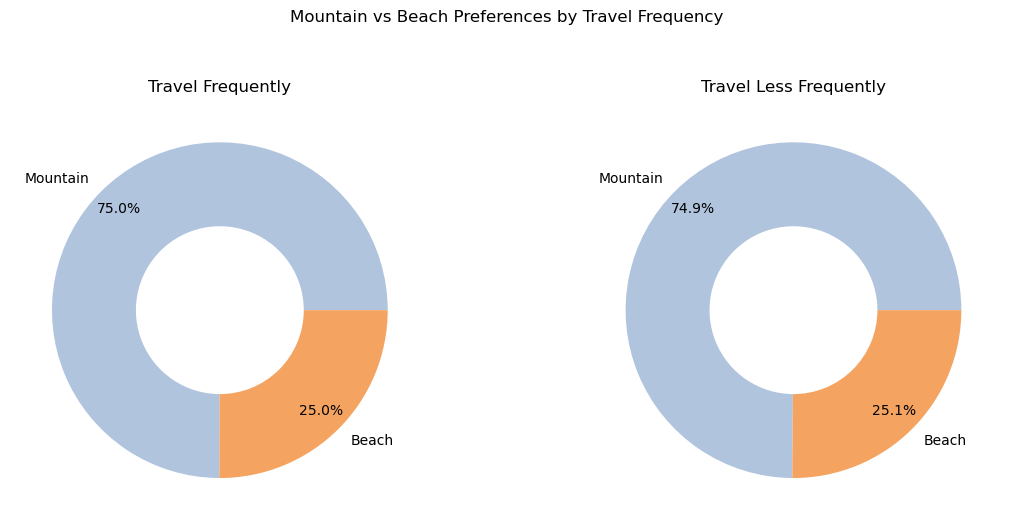

In [10]:
# Calculate the values for each group
freq_counts = df[df['Travel_Frequency'] == 'frequent']['Preference'].value_counts()
not_freq_counts = df[df['Travel_Frequency'] == 'not_frequent']['Preference'].value_counts()

# Create the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Colors for the charts
colors = ['lightsteelblue', 'sandybrown']

# Travel Frequently donut
freq_sizes = [freq_counts.get(0, 0), freq_counts.get(1, 0)]
freq_percentages = [count/sum(freq_sizes)*100 for count in freq_sizes]
ax1.pie(freq_sizes, labels=['Mountain', 'Beach'], 
        autopct='%.1f%%',
        colors=colors, 
        radius=1, 
        pctdistance=0.85,
        wedgeprops=dict(width=0.5))
ax1.set_title('Travel Frequently')

# Travel Less Frequently donut
not_freq_sizes = [not_freq_counts.get(0, 0), not_freq_counts.get(1, 0)]
not_freq_percentages = [count/sum(not_freq_sizes)*100 for count in not_freq_sizes]
ax2.pie(not_freq_sizes, labels=['Mountain', 'Beach'], 
        autopct='%.1f%%',
        colors=colors, 
        radius=1, 
        pctdistance=0.85,
        wedgeprops=dict(width=0.5))
ax2.set_title('Travel Less Frequently')

# Add main title
plt.suptitle('Mountain vs Beach Preferences by Travel Frequency', y=1.05)

plt.tight_layout()
plt.show()

I created two donut charts to visually represent the mountain versus beach preferences between frequent and less frequent travelers. The visualization shows the proportional distribution of preferences in each group, with each donut chart clearly labeled and using a consistent color scheme of lightsteelblue and sandybrown to represent mountains and beaches respectively. Among frequent travelers, approximately 75% prefer mountains and 25% prefer beaches, while less frequent travelers show a remarkably similar distribution with about 75% favoring mountains and 25% favoring beaches. The donut charts were positioned side by side for easy comparison, with percentages clearly displayed on each segment, and the overall layout includes a main title for clear context. This visualization effectively illustrates that both frequent and less frequent travelers have nearly identical preferences, suggesting that travel frequency does not significantly influence the choice between mountains and beaches.

In [11]:
# Create contingency table from original data
contingency = pd.crosstab(df['Travel_Frequency'], df['Preference'])
print("\nContingency Table (Raw Counts):")
print("Columns: 0=Mountain, 1=Beach")
print(contingency)

# Run chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency)

# Print resultsc
print("\nChi-square Test Results:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")


Contingency Table (Raw Counts):
Columns: 0=Mountain, 1=Beach
Preference            0     1
Travel_Frequency             
frequent          23562  7872
not_frequent      15734  5276

Chi-square Test Results:
Chi-square statistic: 0.0283
p-value: 0.8665
Degrees of freedom: 1


We conducted a chi-square test of independence to examine the relationship between travel frequency and preferences for mountains versus beaches. The analysis was based on a contingency table showing that among frequent travelers, 23,562 preferred mountains and 7,872 preferred beaches, while among less frequent travelers, 15,734 preferred mountains and 5,276 preferred beaches. The chi-square test yielded a statistic of 0.0283 with a p-value of 0.8665 and one degree of freedom. The high p-value (well above the conventional significance level of 0.05) indicates strong evidence for failing to reject the null hypothesis, suggesting there is no significant association between travel frequency and preference for mountains versus beaches. This statistical finding aligns with the visual observation from the donut charts, confirming that both frequent and less frequent travelers show similar preference patterns, with approximately 75% preferring mountains in both groups.

The analysis reveals there is no significant relationship between how frequently people travel and their preference for mountains versus beaches. This conclusion is supported by both statistical evidence and visual representation. The chi-square test yielded a high p-value of 0.8665, far exceeding the conventional 0.05 significance level, indicating no statistical association between travel frequency and destination preference. The visualization through donut charts further reinforces this finding, showing remarkably similar preference distributions between frequent and less frequent travelers, with both groups displaying approximately 75% preference for mountains and 25% for beaches. This consistent pattern suggests that the choice between mountain and beach destinations is likely influenced by other factors not related to travel frequency. The robust alignment between statistical testing and visual analysis strengthens the reliability of these findings, indicating that travel planners and tourism services should not assume that frequent travelers have different mountain/beach preferences compared to less frequent travelers.

### Question 3
Do Summer Lovers Prefer Beaches?​

In [12]:
# Group "Summer" and "Other Seasons"
df['Season_Group'] = df['Favorite_Season'].apply(lambda x: 'Summer' if x == 'summer' else 'Other Seasons')
# Verify the grouping
season_group_counts = df['Season_Group'].value_counts()
print(season_group_counts)

Season_Group
Other Seasons    39141
Summer           13303
Name: count, dtype: int64


In [13]:
# Map the Preference column for better interpretation (assuming 0: Mountains, 1: Beaches)
# Map the Preference column to meaningful labels
df['Preference_Label'] = df['Preference'].map({0: 'Mountains', 1: 'Beaches'})
print(df['Preference_Label'].value_counts())
# Cross-tabulation of Favorite_Season vs Preference
season_preference_ct = pd.crosstab(df['Season_Group'], df['Preference_Label'])
print(season_preference_ct)

Preference_Label
Mountains    39296
Beaches      13148
Name: count, dtype: int64
Preference_Label  Beaches  Mountains
Season_Group                        
Other Seasons        9848      29293
Summer               3300      10003


In [14]:
# Normalize the cross-tabulation by row to calculate proportions
season_preference_ratio = season_preference_ct.div(season_preference_ct.sum(axis=1), axis=0)

season_preference_ct.sum(axis=1) computes the total count for each row (i.e., the total preferences within each season group):

For Summer: 3300 (Beaches) + 10003 (Mountains) = 13303

For Other Seasons: 9848 (Beaches) + 29293 (Mountains) = 39141

The .div(..., axis=0) divides each element in season_preference_ct by the corresponding row total. Since axis=0 specifies rows, the division happens row-wise.

For example:

#### For Summer:

**Proportion of Beaches:**

3300/
13303
≈
0.248


**Proportion of Mountains:**

10003/
13303
≈
0.752

#### For Other Seasons:

**Proportion of Beaches:**

39141/
9848
​
 ≈0.251

**Proportion of Mountains:**

39141/
29293
​
 ≈0.749

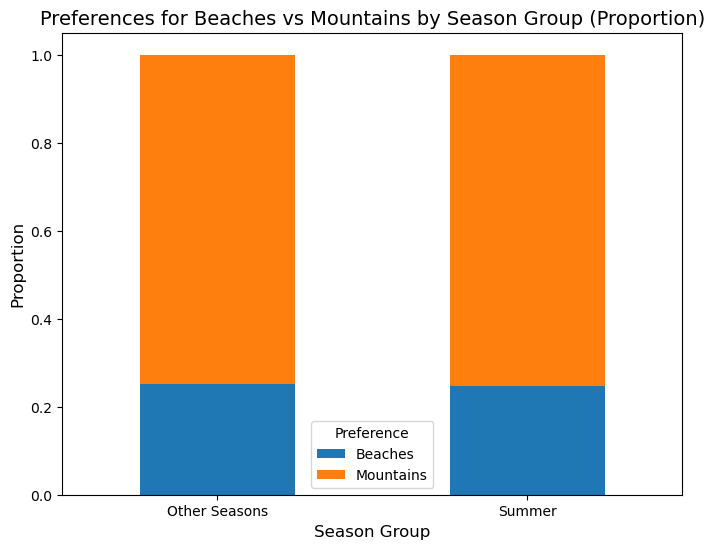

In [15]:
# Plot the normalized data
season_preference_ratio.plot(kind='bar', figsize=(8, 6), stacked=True)

# Customize the plot
plt.title('Preferences for Beaches vs Mountains by Season Group (Proportion)', fontsize=14)
plt.xlabel('Season Group', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Preference', fontsize=10)
plt.show()


After normalization, we eliminate the influence of the total group size, allowing us to directly compare proportions and better identify genuine preference differences.

If we use absolute counts, groups with larger sizes will dominate the analysis. Normalization brings all groups to the same scale, enabling a fairer comparison across them.

#### Perform statistical analysis:

A chi-square test is used to determine whether there is a significant association
between two categorical variables: Season Group (Summer vs. Other Seasons)
and Vacation Preference (Beaches vs. Mountains).

**Null Hypothesis** (
H
0
​
 ):
There is no association between the season group (Summer vs. Other Seasons) and vacation preferences (Beaches vs. Mountains). This means the two variables are independent.

**Alternative Hypothesis** (
H
1
​
 ):
There is an association between the season group (Summer vs. Other Seasons) and vacation preferences (Beaches vs. Mountains). This means the two variables are dependent.
- `season_preference_ct` is the cross-tabulation of observed counts.
- `chi2_contingency` computes:
- Chi-square statistic (`chi2`): measures the divergence of observed data
from what is expected under the null hypothesis (independence).
- p-value (`p`): determines statistical significance.
- Degrees of Freedom (`dof`): number of independent values in the data.
- Expected frequencies (`expected`): theoretical counts assuming independence.


In [16]:
from scipy.stats import chi2_contingency

# Perform a chi-square test on the original cross-tabulation (counts)
chi2, p, dof, expected = chi2_contingency(season_preference_ct)

# Output the results of the chi-square test
statistical_analysis_results = {
    "Chi-square Statistic": chi2,
    "p-value": p,
    "Degrees of Freedom": dof,
    "Expected Frequencies": expected
}

print(statistical_analysis_results)

# Set significance level
alpha = 0.05
print("p-value is " + str(p))
if p <= alpha:
    print("Dependent (reject H0): There is a significant association between Season Group and Preference.")
else:
    print("Independent (H0 holds true): There is no significant association between Season Group and Preference.")




{'Chi-square Statistic': 0.6431907153672198, 'p-value': 0.42255774916656974, 'Degrees of Freedom': 1, 'Expected Frequencies': array([[ 9812.86454122, 29328.13545878],
       [ 3335.13545878,  9967.86454122]])}
p-value is 0.42255774916656974
Independent (H0 holds true): There is no significant association between Season Group and Preference.


The high p-value (0.835) suggests that there is no statistically significant association between the favorite season and the preference for beaches or mountains. This implies that people's preferences for beaches or mountains are not strongly influenced by their favorite season, including summer.




/var/folders/dv/_l_gwqk95zdggctvnm04j3780000gn/T/ipykernel_75066/1828973760.py:20: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  ax.legend(handles=handles[:2] + handles[2:], labels=legend_labels, title="Preferences", loc='upper right')


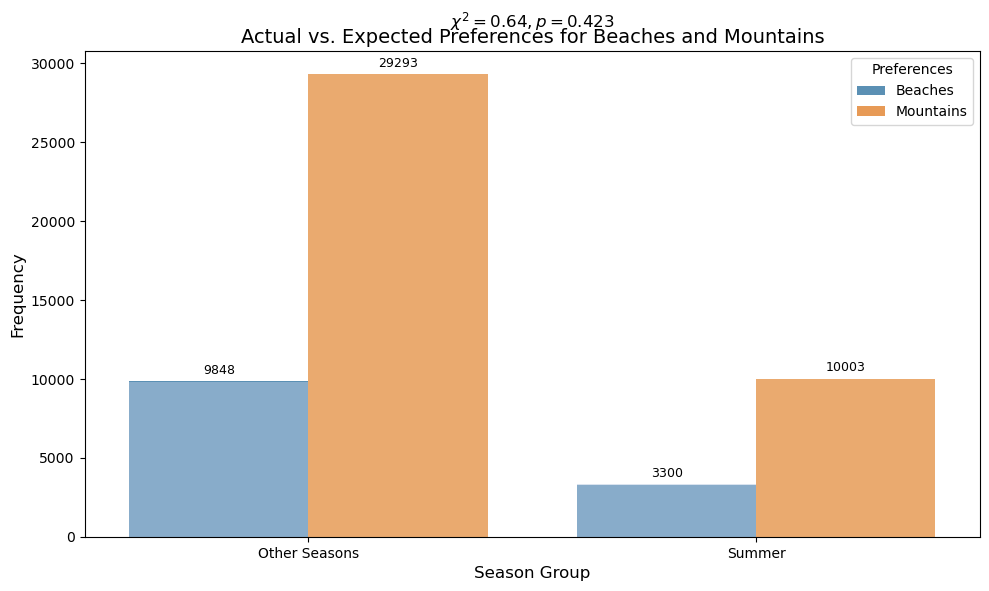

'/content/fixed_preference_plot.png'

In [18]:
# Ensure expected_df has meaningful column names and indices
expected_df = pd.DataFrame(expected, columns=season_preference_ct.columns, index=season_preference_ct.index)

# Visualize actual vs expected frequencies
fig, ax = plt.subplots(figsize=(10, 6))

# Actual frequencies
actual_colors = ['#1f77b4', '#ff7f0e']  # Blue and orange for actual
sns.barplot(data=season_preference_ct.reset_index().melt(id_vars='Season_Group'),
            x='Season_Group', y='value', hue='Preference_Label', palette=actual_colors, ax=ax, alpha=0.8)

# Expected frequencies
expected_colors = ['#aec7e8', '#ffbb78']  # Light blue and light orange for expected
sns.barplot(data=expected_df.reset_index().melt(id_vars='Season_Group'),
            x='Season_Group', y='value', hue='Preference_Label', palette=expected_colors, ax=ax, alpha=0.5)

# Adjust the legend to distinguish actual vs expected
handles, labels = ax.get_legend_handles_labels()
legend_labels = ["Beaches", "Mountains"]
ax.legend(handles=handles[:2] + handles[2:], labels=legend_labels, title="Preferences", loc='upper right')

# Annotate bars with values
for i, bar in enumerate(ax.patches[:len(season_preference_ct.values.flatten())]):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 500,
            f"{int(bar.get_height())}", ha='center', fontsize=9)

# Add chi-square test result to the plot
ax.text(0.5, max(season_preference_ct.values.flatten()) + 3000,
        f"$\\chi^2 = {chi2:.2f}, p = {p:.3f}$", ha='center', fontsize=12)

# Add titles and labels
plt.title("Actual vs. Expected Preferences for Beaches and Mountains", fontsize=14)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Season Group", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save and display the plot
fixed_plot_path = "/content/fixed_preference_plot.png"
plt.show()

fixed_plot_path



- The analysis shows no strong evidence to suggest that people who like summer
prefer beaches over mountains more than those who like other seasons.
- Normalizing group sizes and using statistical tests ensures that the analysis
is fair and interpretable, even for groups of differing sizes.

### Question 4
How Education Affect the Preference between Beach and Mountain ​

In the following code, we tested whether education level influences customers' preference for beaches or mountains. The chosen statistical method is the Chi-Squared test, which is appropriate for examining the independence or association between two categorical variables. In this case, both preferences and education levels are categorical.

To perform the analysis, we first selected the relevant columns (Education Level and Preferences) and structured the data to fit the requirements of the Chi-Squared test. Using statistical packages in Python, we conducted the test and evaluated the resulting p-value to assess significance.

Additionally, we visualized the results using a heatmap and a 3D plot of residuals. These visualizations highlight which groups show significant deviations and the direction of those deviations, providing deeper insights into the relationship between the variables.

Contingency Table:
Preference           0     1
Education_Level             
bachelor          9788  3339
doctorate        10065  3228
high school       9722  3350
master            9721  3231

Chi-Squared Statistic: 7.581749749051974
P-value: 0.05549474101212034
Degrees of Freedom: 3
Expected Frequencies:
[[9835.98871177 3291.01128823]
 [9960.37159637 3332.62840363]
 [9794.77751506 3277.22248494]
 [9704.8621768  3247.1378232 ]]

There is a statistically significant difference in Preference across Education Levels.


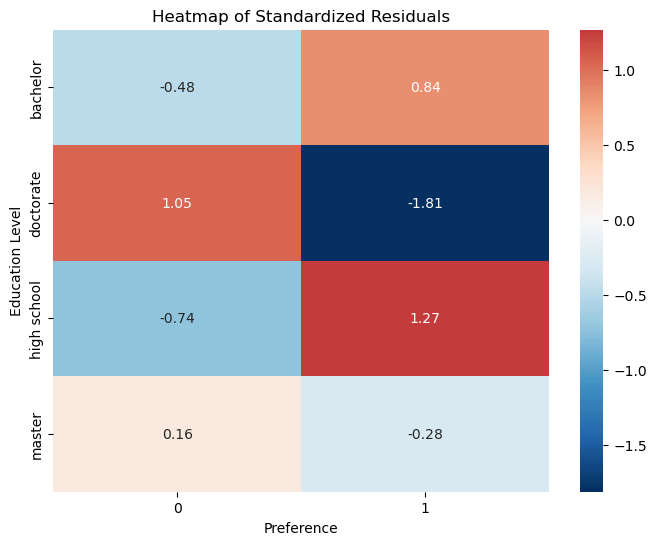

In [19]:
# contingency_table
contingency_table = pd.crosstab(df['Education_Level'], df['Preference'])

# Perform the Chi-Squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Contingency Table:")
print(contingency_table)
print("\nChi-Squared Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)

alpha = 0.1 # we choose 0.1 rather than 0.05 because prioritise is given to recall over precision
if p < alpha:
    print("\nThere is a statistically significant difference in Preference across Education Levels.")
else:
    print("\nNo statistically significant difference in Preference across Education Levels.")

# Calculate and visualize standardized residuals
observed = contingency_table.values 
standardized_residuals = (observed - expected) / (expected ** 0.5)

residuals_df = pd.DataFrame(
    standardized_residuals,
    index=contingency_table.index,
    columns=contingency_table.columns
)

plt.figure(figsize=(8, 6))
sns.heatmap(residuals_df,annot=True, fmt=".2f",cmap="RdBu_r", center=0)
plt.title("Heatmap of Standardized Residuals")
plt.xlabel("Preference")
plt.ylabel("Education Level")
plt.show()

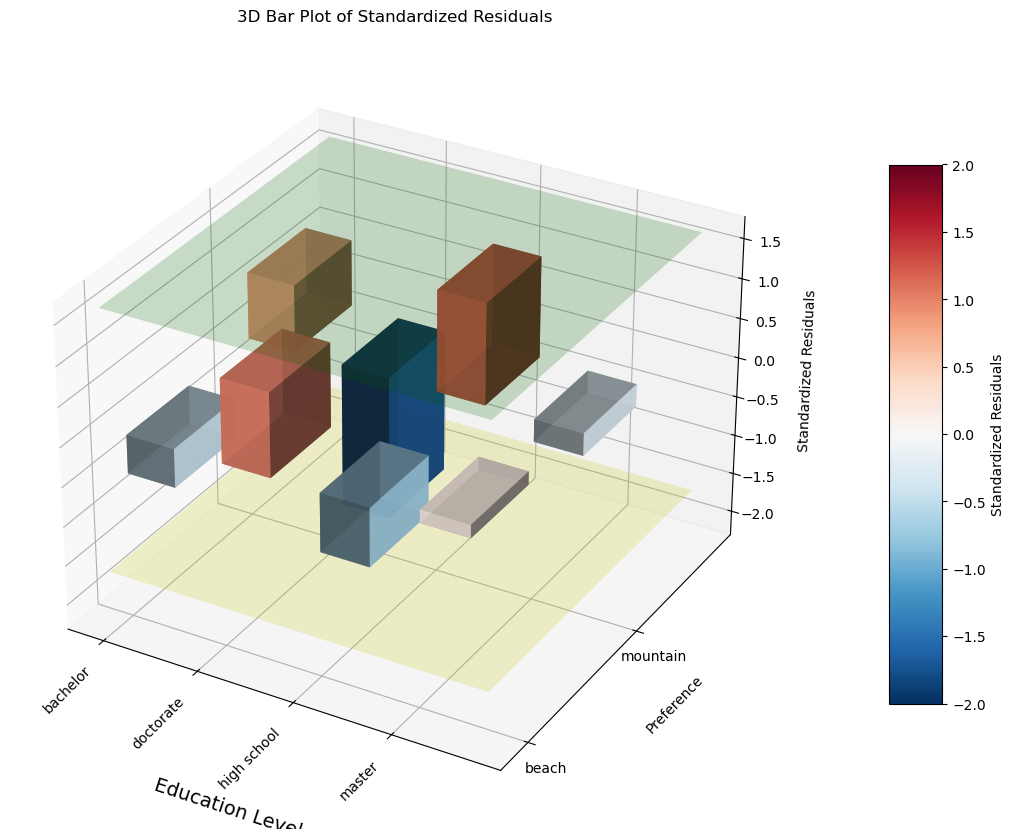

In [20]:
# visualization:)
# Our 3D plot is interactive, allowing viewers to explore relationships from different perspectives - achievable in jupyter lab
x_labels = contingency_table.index.tolist()  # Education levels
y_labels = ['beach','mountain']
x_pos, y_pos = np.meshgrid(np.arange(len(x_labels)), np.arange(len(y_labels)), indexing="ij")

# Flatten the data for easier plotting
x_pos_flat = x_pos.ravel()
y_pos_flat = y_pos.ravel()
z_pos_flat = np.zeros_like(x_pos_flat) 
residuals_flat = standardized_residuals.ravel()

# Bar heights correspond to residuals
bar_heights = residuals_flat
colormap = plt.cm.RdBu_r  # best colours ever:D
norm = Normalize(vmin=-2, vmax=2) # ensure that color corresponds better to values
colors = colormap(norm(bar_heights))

fig = plt.figure(figsize=(14, 10))
ax2 = fig.add_subplot(111, projection='3d')

bars = ax2.bar3d(
    x_pos_flat, y_pos_flat, z_pos_flat, 
    dx=0.5, dy=0.5, dz=bar_heights,     
    color=colors, alpha=0.8
)

# modify details of the plot
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_xticklabels(x_labels, rotation=45, ha='right')  # Rotate and align x-axis labels
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_yticklabels(y_labels)
ax2.set_xlabel("Education Level", labelpad=35, fontsize=14)  # Add padding for better spacing
ax2.set_ylabel("Preference", labelpad=15)
ax2.set_zlabel("Standardized Residuals", labelpad=10)

z_min, z_max = bar_heights.min(), bar_heights.max()
ax2.set_zlim(z_min - 0.5, z_max + 0.5)  

x_range = np.arange(-0.1, len(x_labels) - 0.1, 0.1) 
y_range = np.arange(-0.1, len(y_labels) - 0.1, 0.1) 
x_plane, y_plane = np.meshgrid(x_range, y_range)

# Positive threshold plane
ax2.plot_surface(
    x_plane, y_plane,  # Plane position
    np.full_like(x_plane, 1.645),  # Z-value for +1.645 - corresponds to alpha = 0.1
    color='green', alpha=0.2, edgecolor='none'  # Transparent green plane
)

# Negative threshold plane
ax2.plot_surface(
    x_plane, y_plane,  # Plane position
    np.full_like(x_plane, -1.645),  # Z-value for -1.645
    color='yellow', alpha=0.2, edgecolor='none'  # Transparent red plane
)

# color bar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=norm), ax=ax2, shrink=0.7, aspect=10, pad=0.1)
cbar.set_label("Standardized Residuals")

plt.title("3D Bar Plot of Standardized Residuals", pad=20)
plt.show()

When evaluating the differences between groups, we set the alpha level (𝛼) to 0.1. This relatively higher threshold for significance reflects our decision to tolerate a certain level of Type I error (false positives) to ensure that more potential differences are detected. In this context, minimizing Type II errors (false negatives) is more critical because missing meaningful differences could negatively impact the ability to customize recommendations. By contrast, the consequences of false positives (Type I errors) are less severe in this application.

The p-value of 0.05549 indicates that the observed differences are statistically significant at the 0.1 significance level but not at the more stringent 0.05 level. This suggests there is moderate evidence to reject the null hypothesis, implying that education level may influence customers' preference for beaches or mountains.

From the heatmap and plots of standardized residuals, we observe that the most significant difference between expected and actual values is found in the preferences of individuals with a doctorate for mountains (-1.8). Specifically, individuals with a doctorate are statistically less likely to prefer mountain travel than expected.



### Question 5
Test If Preferred Activity Affect the preference between Beach and Mountain

The same approach was employed to test whether Preferred Activity affects the preference between Beach and Mountain. While we may have some intuition about how different activity preferences might influence preferences between mountain and beach, it is important to validate these assumptions statistically to ensure that our recommendations are both accurate and useful.

Contingency Table:
Preference                0     1
Preferred_Activities             
hiking                 6539  6563
skiing                 6582  6585
sunbathing            13221     0
swimming              12954     0

Chi-Squared Statistic: 17484.405386952938
P-value: 0.0
Degrees of Freedom: 3
Expected Frequencies:
[[9817.25634963 3284.74365037]
 [9865.96049119 3301.03950881]
 [9906.42239341 3314.57760659]
 [9706.36076577 3247.63923423]]

There is a statistically significant difference in Preference across Education Levels.


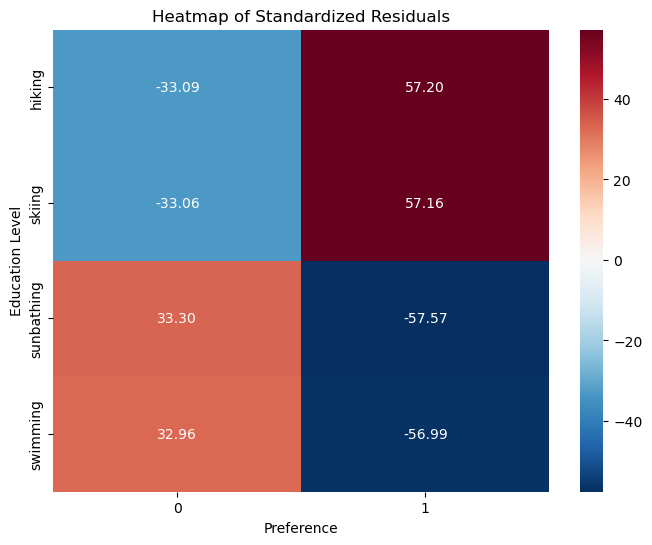

In [21]:
contingency_table = pd.crosstab(df['Preferred_Activities'], df['Preference'])

# Perform the Chi-Squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Contingency Table:")
print(contingency_table)
print("\nChi-Squared Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)

alpha = 0.1
if p < alpha:
    print("\nThere is a statistically significant difference in Preference across Education Levels.")
else:
    print("\nNo statistically significant difference in Preference across Education Levels.")

# Calculate standardized residuals
observed = contingency_table.values  # Observed frequencies
standardized_residuals = (observed - expected) / (expected ** 0.5)

residuals_df = pd.DataFrame(
    standardized_residuals,
    index=contingency_table.index,
    columns=contingency_table.columns
)

plt.figure(figsize=(8, 6))
sns.heatmap(residuals_df,annot=True, fmt=".2f",cmap="RdBu_r", center=0)
plt.title("Heatmap of Standardized Residuals")
plt.xlabel("Preference")
plt.ylabel("Education Level")
plt.show()

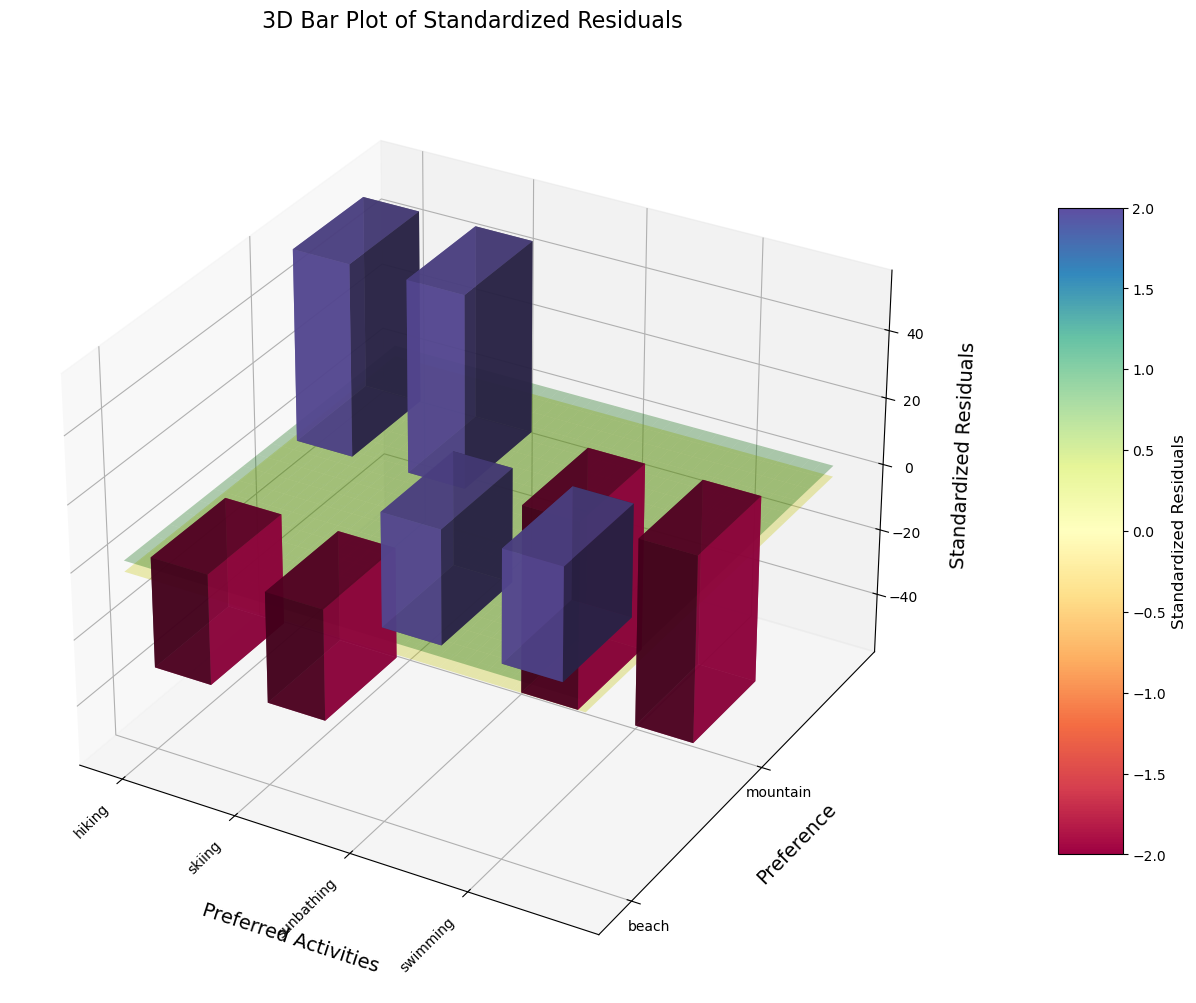

In [22]:
# Step 1: Create a contingency table for Preference by Education_Level
contingency_table = pd.crosstab(df['Preferred_Activities'], df['Preference'])

# Step 2: Perform the Chi-Squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Step 3: Calculate standardized residuals
observed = contingency_table.values  # Observed frequencies
standardized_residuals = (observed - expected) / (expected ** 0.5)

# Step 4: Prepare data for plotting
x_labels = contingency_table.index.tolist()  # Activities
y_labels = ['beach', 'mountain']
x_pos, y_pos = np.meshgrid(np.arange(len(x_labels)), np.arange(len(y_labels)), indexing="ij")

# Flatten the data for easier plotting
x_pos_flat = x_pos.ravel()
y_pos_flat = y_pos.ravel()
z_pos_flat = np.zeros_like(x_pos_flat)  # All bars start at 0
residuals_flat = standardized_residuals.ravel()

# Bar heights correspond to residuals
bar_heights = residuals_flat

# Colors based on residual values with vibrant colormap
from matplotlib.colors import Normalize
colormap = plt.cm.Spectral  # Vibrant colormap
norm = Normalize(vmin=-2, vmax=2)  # Normalize to standard thresholds
colors = colormap(norm(bar_heights))

# Step 5: Create a 3D bar plot
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot the bars
bars = ax.bar3d(
    x_pos_flat, y_pos_flat, z_pos_flat,  # Bar positions
    dx=0.5, dy=0.5, dz=bar_heights,     # Bar dimensions
    color=colors, alpha=0.8
)

# Set axis labels
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')  # Rotate and align x-axis labels
ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels(y_labels)
ax.set_xlabel("Preferred Activities", labelpad=25, fontsize=14)  # Add padding for better spacing
ax.set_ylabel("Preference", labelpad=15, fontsize=14)
ax.set_zlabel("Standardized Residuals", labelpad=15, fontsize=14)

# Adjust Z axis to show negative values
z_min, z_max = bar_heights.min(), bar_heights.max()
ax.set_zlim(z_min - 0.5, z_max + 0.5)  

# Add transparent threshold planes for ±1.645
x_range = np.arange(-0.1, len(x_labels) - 0.1, 0.1) 
y_range = np.arange(-0.1, len(y_labels) - 0.1, 0.1) 
x_plane, y_plane = np.meshgrid(x_range, y_range)

# Positive threshold plane
ax.plot_surface(
    x_plane, y_plane,  # Plane position
    np.full_like(x_plane, 1.645),  # Z-value for +1.645
    color='green', alpha=0.3, edgecolor='none'  
)

# Negative threshold plane
ax.plot_surface(
    x_plane, y_plane,  # Plane position
    np.full_like(x_plane, -1.645),  # Z-value for -1.645
    color='yellow', alpha=0.3, edgecolor='none'  
)

# Add a color bar for residuals
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=norm), ax=ax, shrink=0.7, aspect=10, pad=0.1)
cbar.set_label("Standardized Residuals", fontsize=12)

# Add a title
plt.title("3D Bar Plot of Standardized Residuals", pad=30, fontsize=16)
plt.show()

Using a Chi-Squared test, the p-value = 0.0 indicates a statistically significant difference between preferences across the different activity groups.There is strong evidence that Preferred Activities significantly influence customers' preferences between Beach and Mountain. Specifically:
Hiking and Skiing align with Mountain preferences. Sunbathing and Swimming align with Beach preferences.